In [101]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set(style="ticks", color_codes=True)
%matplotlib inline

# Load and Clean Data

In [102]:
# read the csv file
df = pd.read_csv('sentiment.csv')
print(df.shape)

(463136, 4)


In [103]:
# delete null row
df.dropna(how='any',inplace=True)
print(df.shape)

(463044, 4)


In [104]:
# find unusual rows
def set_as_nan(x):
    if x == 'time':
        return np.nan
    else:
        return x
df['time'] = df['time'].map(set_as_nan)

In [105]:
# delete unusual rows
df.dropna(how='any',inplace=True)
print(df.shape)

(463037, 4)


In [106]:
# select columns
df = df[['time','score','magnitude']]

In [107]:
df['score'] = df['score'].map(lambda x:float(x))
df['magnitude'] = df['magnitude'].map(lambda x:float(x))
df['sentiment'] = df['score'] * df['magnitude']

In [108]:
df = pd.DataFrame(df.groupby(['time'])['score','magnitude','sentiment'].mean())
df = df.reset_index()
df = df.sort_values('time')

In [109]:
df1 = pd.read_csv('hot.csv')
df2 = pd.read_csv('bitcoinprice.csv')
df1 = df1.sort_values(by='date')
df1.columns = ['time','googleview']
df2 = df2.sort_values(by='time')
df2.columns = ['time','price']
df1 = df1.reset_index()
df1 = df1[['time','googleview']]
df3 = pd.read_csv('transaction.csv')
df3 = df3.sort_values(by='Date')
df3.columns = ['time','volume']
df3 = df3.reset_index()
df3 = df3[['time','volume']]

In [110]:
df = df.merge(df1,how='inner',on='time')
df = df.merge(df2,how='inner',on='time')
df = df.merge(df3,how='inner',on='time')

# Day as Grain

In [111]:
df.head()

,time,score,magnitude,sentiment,googleview,price,volume
0,2013-01-01,0.225000,0.334615,0.145577,43,13.3,206393.933073
1,2013-01-02,0.045455,0.321212,0.014242,72,13.3,323579.699353
2,2013-01-03,0.057692,0.475000,0.025192,24,13.4,225268.834681
3,2013-01-04,0.067273,0.340000,0.035091,26,13.5,271212.893537
4,2013-01-05,-0.002083,0.347917,-0.016458,91,13.4,198361.221945


In [112]:
# normalize
from sklearn import preprocessing
x = df[['score','magnitude','sentiment','googleview','price','volume']].values #returns a numpy array
min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled)
df_temp.columns = ['score','magnitude','sentiment','googleview','price','volume']
df_temp['time'] = df['time']
df = df_temp
df = df[['time','score','magnitude','sentiment','googleview','price','volume']]

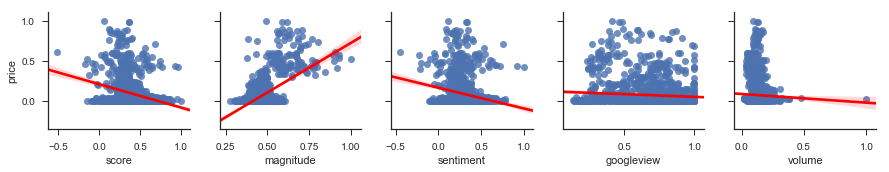

In [113]:
pairp = sns.pairplot(df[['score','magnitude','sentiment','googleview','price','volume']],
                     kind='reg',
                     plot_kws={'line_kws':{'color':'red'}},
                     x_vars=["score", "magnitude",'sentiment',"googleview",'volume'],
                     y_vars=["price"])

In [114]:
df.columns = ['date','score','magnitude','sentiment','googleview','price','volume']

In [115]:
df.head()

,date,score,magnitude,sentiment,googleview,price,volume
0,2013-01-01,0.799699,0.405594,0.577686,0.43,0.000693,0.102127
1,2013-01-02,0.161555,0.389348,0.056518,0.72,0.000693,0.160112
2,2013-01-03,0.205051,0.575758,0.099969,0.24,0.000698,0.111467
3,2013-01-04,0.239102,0.412121,0.139250,0.26,0.000704,0.134200
4,2013-01-05,-0.007405,0.421717,-0.065311,0.91,0.000698,0.098152


# Month as Grain

In [116]:
df['month'] = df['date'].map(lambda x:x[5:7])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
df['year'] = df['date'].map(lambda x:x[0:4])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
df['day'] = df['date'].map(lambda x:x[8:11])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
df = df[['year','month','day','score','magnitude','sentiment','googleview','price','volume']]

In [120]:
gdf = pd.DataFrame(df.groupby(['year','month'])['score','magnitude','sentiment','googleview','price','volume'].mean()).reset_index()

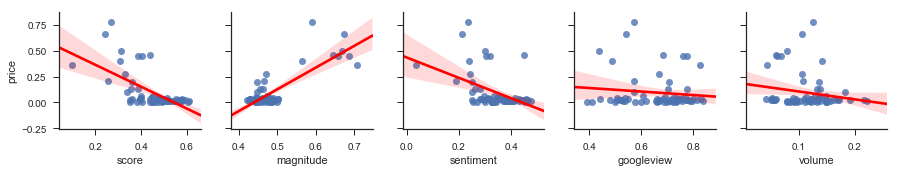

In [122]:
pairp = sns.pairplot(gdf[['score','magnitude','sentiment','googleview','price','volume']],
                     kind='reg',
                     plot_kws={'line_kws':{'color':'red'}},
                     x_vars=["score", "magnitude",'sentiment',"googleview",'volume'],
                     y_vars=["price"])

# Lagging Insight

In [123]:
# lagged function
def lag(data,n=1):
    data = list(data)
    lagged_data = [data[i] for i in range(n,len(data))]
    for i in range(0,n):
        lagged_data.append(np.nan)
    return pd.Series(lagged_data)

In [124]:
gdf['sentiment_lag1'] = lag(gdf['sentiment'])
gdf['score_lag1'] = lag(gdf['score'])
gdf['magnitude_lag1'] = lag(gdf['magnitude'])
gdf['googleview_lag1'] = lag(gdf['googleview'])
gdf['volume_lag1'] = lag(gdf['volume'])

gdf['sentiment_lag2'] = lag(gdf['sentiment'],2)
gdf['score_lag2'] = lag(gdf['score'],2)
gdf['magnitude_lag2'] = lag(gdf['magnitude'],2)
gdf['googleview_lag2'] = lag(gdf['googleview'],2)
gdf['volume_lag2'] = lag(gdf['volume'],2)

gdf['sentiment_lag3'] = lag(gdf['sentiment'],3)
gdf['score_lag3'] = lag(gdf['score'],3)
gdf['magnitude_lag3'] = lag(gdf['magnitude'],3)
gdf['googleview_lag3'] = lag(gdf['googleview'],3)
gdf['volume_lag3'] = lag(gdf['volume'],3)

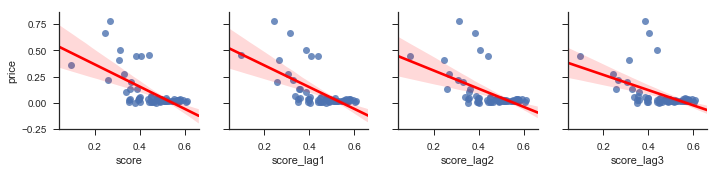

In [125]:
pairp = sns.pairplot(gdf[list(gdf.columns[2:])],
                     kind='reg',
                     plot_kws={'line_kws': {'color': 'red'}},
                     x_vars=['score',
                             'score_lag1',
                             'score_lag2',
                             'score_lag3',],
                     y_vars=["price"])

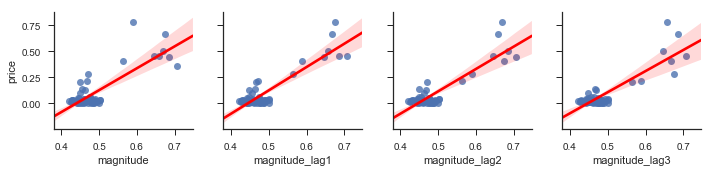

In [126]:
pairp = sns.pairplot(gdf[list(gdf.columns[2:])],
                     kind='reg',
                     plot_kws={'line_kws': {'color': 'red'}},
                     x_vars=['magnitude',
                             'magnitude_lag1',
                             'magnitude_lag2',
                             'magnitude_lag3'],
                     y_vars=["price"])

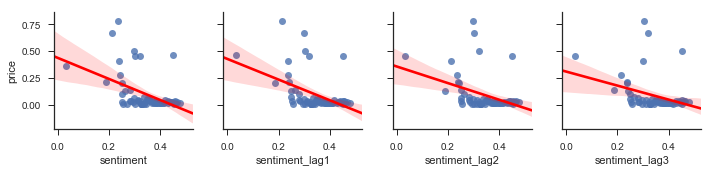

In [127]:
pairp = sns.pairplot(gdf[list(gdf.columns[2:])],
                     kind='reg',
                     plot_kws={'line_kws': {'color': 'red'}},
                     x_vars=['sentiment',
                             'sentiment_lag1',
                             'sentiment_lag2',
                             'sentiment_lag3'],
                     y_vars=["price"])

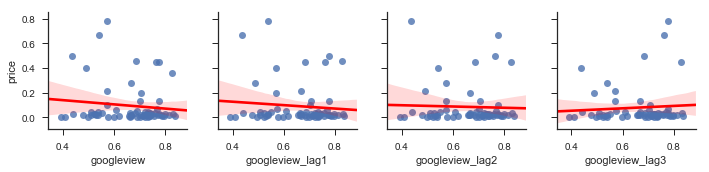

In [128]:
pairp = sns.pairplot(gdf[list(gdf.columns[2:])],
                     kind='reg',
                     plot_kws={'line_kws': {'color': 'red'}},
                     x_vars=['googleview',
                             'googleview_lag1',
                             'googleview_lag2',
                             'googleview_lag3'],
                     y_vars=["price"])

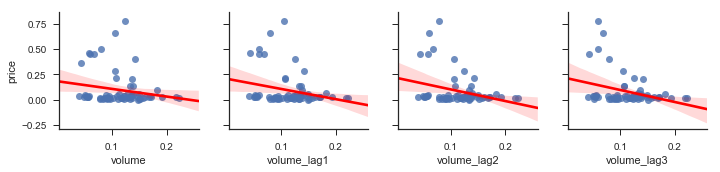

In [129]:
pairp = sns.pairplot(gdf[list(gdf.columns[2:])],
                     kind='reg',
                     plot_kws={'line_kws': {'color': 'red'}},
                     x_vars=['volume',
                             'volume_lag1',
                             'volume_lag2',
                             'volume_lag3'],
                     y_vars=["price"])

# Multiple Variable Regression

In [130]:
gdf=gdf.dropna()
for i in range(0,4):
    if i==0:
        reg=LinearRegression().fit(gdf[['sentiment','score','magnitude','googleview','volume']],gdf[['price']])
        print("Current Variable Regression")
        score = reg.score(gdf[['sentiment','score','magnitude','googleview','volume']],gdf[['price']])
    else:
        reg=LinearRegression().fit(gdf[['sentiment_lag'+str(i),'score_lag'+str(i),
                                        'magnitude_lag'+str(i),'googleview_lag'+str(i),
                                       'volume_lag'+str(i)]],gdf[['price']])
        print("Lag "+str(i)+" Variable Regression")
        score = reg.score(gdf[['sentiment_lag'+str(i),
                       'score_lag'+str(i),      
                       'magnitude_lag'+str(i),
                       'googleview_lag'+str(i),
                              'volume_lag'+str(i)]],gdf[['price']])
    print('Score: %.2f' % score )    

Current Variable Regression
Score: 0.81
Lag 1 Variable Regression
Score: 0.88
Lag 2 Variable Regression
Score: 0.83
Lag 3 Variable Regression
Score: 0.80
